## Deploying CNTK to Azure Container

Original write-up by Raymond + Tudor: 

[https://github.com/Azure/Spark-Operationalization-On-Azure/blob/master/samples/cntk/tutorials/realtime/image_classification.md](https://github.com/Azure/Spark-Operationalization-On-Azure/blob/master/samples/cntk/tutorials/realtime/image_classification.md)

### Why is this just great?

1. One-click deploy of DNN! Get all of our git-repo DNNs up as a web-service ...
    ```
    aml service create realtime -r cntk-py -f driver.py -m ResNet_152.model -d synset.txt -n demoservice
    ```
   Syntax:
   ```
   aml service create realtime -f <webservice file> -n <service name> [-m <model1> [-m <model2>] ...] [-p requirements.txt] [-s <schema>] [-r spark-py|cntk-py|tensorflow-py]
   ```
   
2. Using docker-containers we can run locally first (to debug with logs)
    ```
    aml env local
    ```
    
3. Docker-containers in general mean we don't have to worry about dependencies and whether it will work in a remote environment (as long as it works locally)

4. Kubernetes support coming soon ... potentially deploy to a GPU cluster in the same way (just toggle option)
5. Reduced latency (optimised for web responses)

**Note - Default cluster is Standard_D2_v2 (3 instances) i.e. of size: Standard D2 v2 (2 cores, 7 GB memory)**

In [ ]:
%%bash
# Syntax
aml service create realtime --help
aml env --help

In [ ]:
# Run the below as root on on your DSVM
# They will install latest azuremlcli & configure docker:

#!wget -q http://amlsamples.blob.core.windows.net/scripts/amlupdate.sh -O - | sudo bash -
#!sudo /opt/microsoft/azureml/initial\_setup.sh

In [ ]:
!aml env setup --name iliahackathon

In [ ]:
!aml env setup -s iliahackathonrgacsdeployment20170322052923

In [ ]:
!cat ~/.amlenvrc

In [7]:
import wget

In [ ]:
# Model
wget.download("https://ikcompuvision.blob.core.windows.net/acs/ResNet_18.model")
wget.download("https://migonzastorage.blob.core.windows.net/deep-learning/models/cntk/imagenet/ResNet_152.model")
# Labels
wget.download("https://ikcompuvision.blob.core.windows.net/acs/synset.txt")
# Python script (driver) (modify load model from _18 to _152)
wget.download("https://ikcompuvision.blob.core.windows.net/acs/driver.py")

In [ ]:
%%bash
# Deploy (local first)
source ~/.amlenvrc
aml env local

In [11]:
%%bash
source ~/.amlenvrc
aml service create realtime -r cntk-py -f driver.py -m ResNet_152.model -d synset.txt -n cntkservice

Process is interrupted.


## Score Image using ACS (local)

In [12]:
localurl = 'http://127.0.0.1:32769/score'

In [13]:
import base64
import urllib
import requests
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from io import BytesIO
%matplotlib inline

In [14]:
IMAGEURL = "https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg"

'{"input": "[\\"iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAEAAElEQVR4nMz9edRkyXUfBt4l4i2Z+a311b70vg'

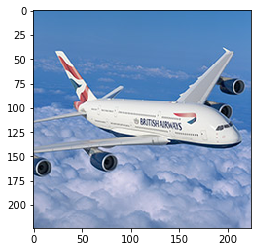

In [15]:
def url_img_to_json_img(url):
    bytfile = BytesIO(urllib.urlopen(url).read())
    img = Image.open(bytfile).convert('RGB')  # 3 Channels
    img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)  # Fixed size 
    plt.imshow(img)
    imgio = BytesIO()
    img.save(imgio, 'PNG')
    imgio.seek(0)
    dataimg = base64.b64encode(imgio.read())
    return json.dumps(
        {'input':'[\"{0}\"]'.format(dataimg.decode('utf-8'))})

jsonimg = url_img_to_json_img(IMAGEURL)
jsonimg[:100]  # Example of json string

In [26]:
headers = {'content-type': 'application/json',
           'X-Marathon-App-Id': '/demoservice'}

In [19]:
%time r = requests.post(localurl, data=jsonimg, headers=headers)

CPU times: user 3.55 ms, sys: 434 µs, total: 3.98 ms
Wall time: 773 ms


In [20]:
r.json()  # Result

{u'result': [[[[u'airliner', 1639.3054962158203],
    [u'wing', 1492.4062728881836],
    [u'space shuttle', 1439.7224426269531]]],
  u'Computed in 764.97 ms']}

## Score Image using ACS (cluster)

In [ ]:
# Have to run this via terminal ... (possible to change?)
#!

In [22]:
!source ~/.amlenvrc; aml service create realtime -r cntk-py -f driver.py -m ResNet_152.model -d synset.txt -n demoservice

Uploading dependencies.
 ResNet_152.model
 synset.txt
 /anaconda/envs/py35/lib/python3.5/site-packages/azuremlcli/azuremlutilities.py
Creating docker image.........done.
Image available at : iliahackathonacr.azurecr.io/demoservice
Deployment id: 2712374f-8b27-45bc-a032-83418f39e6d0
Success.
Usage: aml service run realtime -n demoservice [-d '{"input" : "!! YOUR DATA HERE !!"}']


In [27]:
# Need to use port 9091
CLUSTER_URL = 'http://iliahackathonacsagent.eastus.cloudapp.azure.com:9091/score'

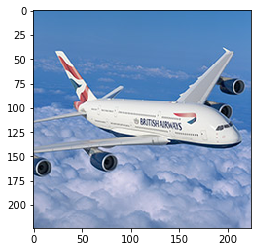

In [28]:
IMAGEURL = "https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg"
jsonimg = url_img_to_json_img(IMAGEURL)

In [33]:
%time r = requests.post(CLUSTER_URL, data=jsonimg, headers=headers)
str(r.json()['result'][0][0][0][0]) # Result

CPU times: user 5.21 ms, sys: 244 µs, total: 5.45 ms
Wall time: 973 ms


'airliner'

## Another Example

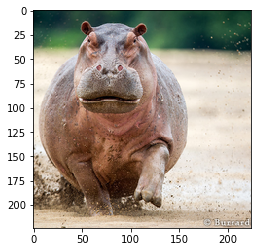

In [34]:
IMAGEURL = 'http://img.burrard-lucas.com/zambia/full/hippo_charge.jpg'
jsonimg = url_img_to_json_img(IMAGEURL)

In [35]:
%time r = requests.post(CLUSTER_URL, data=jsonimg, headers=headers)
str(r.json()['result'][0][0][0][0]) # Result

CPU times: user 3.4 ms, sys: 342 µs, total: 3.74 ms
Wall time: 978 ms


'hippopotamus'

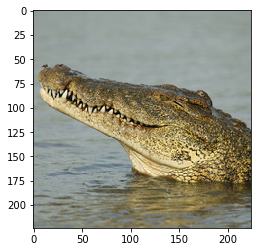

In [36]:
IMAGEURL = 'http://news.nationalgeographic.com/content/dam/news/2016/05/24/nile-crocodile/01-nile-crocodile-florida.jpg'
jsonimg = url_img_to_json_img(IMAGEURL)

In [37]:
%time r = requests.post(CLUSTER_URL, data=jsonimg, headers=headers)
str(r.json()['result'][0][0][0][0]) # Result

CPU times: user 4.27 ms, sys: 0 ns, total: 4.27 ms
Wall time: 968 ms


'African crocodile'

## Compare this to submitting a VM (similar-size model; Flask; gunicorn)

In [38]:
fname = urllib.urlretrieve(IMAGEURL, "test.jpg")[0]

In [39]:
url = "http://appresnet.uksouth.cloudapp.azure.com/uploader_ios"
files = {'imagefile': open(fname, 'rb')}

In [40]:
%time requests.post(url, files=files).json()['English']

CPU times: user 1.71 ms, sys: 4.22 ms, total: 5.94 ms
Wall time: 2.37 s


u'crocodile'